In [1]:
%load_ext autoreload
%autoreload 2

import os
import sys
N_up = 1
repo_dir = '/'.join(os.getcwd().split('/')[:-N_up])
if repo_dir not in sys.path:
    sys.path.append(repo_dir)
    
import numpy as np

from scipy.stats import multivariate_normal

%matplotlib inline
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

from torchdiffeq import odeint_adjoint as odeint
# from torchdiffeq import odeint

from src.datasets import energy_function_1, energy_function_2, energy_function_3, energy_function_4

In [2]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
cvt = lambda x: torch.tensor(x).type(torch.float32).to(device, non_blocking=True)

In [3]:
def get_batch(batch_size):
    p = multivariate_normal(mean=[0., 0.], cov=[[1., 0.], [0., 1.]])
    z_0 = p.rvs(batch_size)
    logpz_0 = p.logpdf(z_0).reshape(-1, 1)

    return (cvt(z_0), cvt(logpz_0))

In [4]:
def trace_df_dz(f, z):
    sum_diag = 0.
    for i in range(z.shape[1]):
        sum_diag += torch.autograd.grad(f[:, i].sum(), z, create_graph=True)[0].contiguous()[:, i].contiguous()
        
    return sum_diag.contiguous()
    
class CNF(nn.Module):
    
    def __init__(self, width, in_out_dim, hidden_dim):
        super(CNF, self).__init__()
        
        self.width = width
        self.in_out_dim = in_out_dim
        self.hidden_dim = hidden_dim
        
        self.hyper = nn.Sequential(
            nn.Linear(1, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.Tanh(),
            nn.Linear(hidden_dim, in_out_dim*width*3 + width)
        )
        # TODO: init weights properly
        
    def forward(self, t, states):
        
        with torch.set_grad_enabled(True):
            z = states[0]
            logp_z = states[1]
            
            batchsize = z.shape[0]
            
            params = self.hyper(t.reshape(1, 1))

            dz_dt = torch.zeros_like(z)
            dlogp_z_dt = torch.zeros_like(logp_z)
            
            z.requires_grad_(True)
            t.requires_grad_(True)

            for n in range(self.width):
                w = params[:, n*self.in_out_dim:
                           (n+1)*self.in_out_dim]
                u = params[:, n*self.in_out_dim + self.in_out_dim*self.width:
                           (n+1)*self.in_out_dim + self.in_out_dim*self.width]
                g = params[:, n*self.in_out_dim + self.in_out_dim*self.width*2:
                           (n+1)*self.in_out_dim + self.in_out_dim*self.width*2]
                b = params[:, self.in_out_dim*self.width*3 + n:
                           self.in_out_dim*self.width*3 + n + 1]

                dz_dt_n = torch.sigmoid(g) * u * torch.tanh(torch.mm(z, w.T) + b)
                dlogp_z_dt_n = -trace_df_dz(dz_dt_n, z).view(batchsize, 1)

                dz_dt += dz_dt_n
                dlogp_z_dt += dlogp_z_dt_n
            
        return (dz_dt, dlogp_z_dt)

In [5]:
# hyper_params
batch_size = 1000
width = 50

In [6]:
odefunc = CNF(
    width = 32,
    in_out_dim = 2,
    hidden_dim = 8
)

if device != "cpu":
    odefunc = odefunc.cuda()

optimizer = optim.Adam(odefunc.parameters(), lr=1e-3, weight_decay=0.)

def calc_loss(z_t, logqz_t):
    logpz_t = energy_function_1(z_t)

    KLD = -logqz_t + logpz_t
    return KLD.mean()

for itr in range(1, 200 + 1):
    optimizer.zero_grad()
    z_0, logpz_0 = get_batch(batch_size)
    
    z_t, logpz_t = odeint(
            odefunc,
            (z_0, logpz_0),
            torch.tensor([0., 1.]).to(z_0),
            atol=1e-5,
            rtol=1e-5,
            method='dopri5',
        )

    z_t, logpz_t = z_t[1], logpz_t[1]
        
    loss = calc_loss(z_t, logpz_t)

    loss.backward()
    optimizer.step()

    if itr % 10 == 0:
        with torch.no_grad():
            z_0, logpz_0 = get_batch(batch_size)
    
            z_t, logpz_t = odeint(
                    odefunc,
                    (z_0, logpz_0),
                    torch.tensor([0., 1.]).to(z_0),
                    atol=1e-5,
                    rtol=1e-5,
                    method='dopri5',
                )

            z_t, logpz_t = z_t[1], logpz_t[1]

            KLD = calc_loss(z_t, logpz_t)
            print('Iter {:04d} | KLD {:.6f}'.format(itr, KLD.item()))

Iter 0010 | KLD 26.786135
Iter 0020 | KLD 23.647106
Iter 0030 | KLD 22.435436
Iter 0040 | KLD 20.415962
Iter 0050 | KLD 17.467667
Iter 0060 | KLD 10.214657
Iter 0070 | KLD 3.721692
Iter 0080 | KLD 0.063210
Iter 0090 | KLD -1.878945
Iter 0100 | KLD -3.780388


KeyboardInterrupt: 

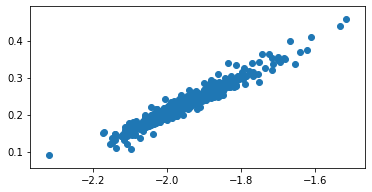

In [7]:
z_0, logpz_0 = get_batch(batch_size)
    
z_t, logpz_t = odeint(
        odefunc,
        (z_0, logpz_0),
        torch.tensor([0., 1.]).to(z_0),
        atol=1e-5,
        rtol=1e-5,
        method='dopri5',
    )

z_t, logpz_t = z_t[1], logpz_t[1]

xy = z_t.cpu().detach().numpy()

plt.scatter(xy[:, 0], xy[:, 1])
# plt.xlim(-4, 4)
# plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
# plt.xticks([])
# plt.yticks([])
plt.show()

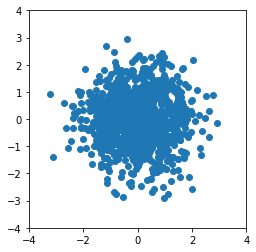

In [8]:
xy = z_0.cpu().detach().numpy()

plt.scatter(xy[:, 0], xy[:, 1])
plt.xlim(-4, 4)
plt.ylim(-4, 4)
plt.gca().set_aspect('equal', adjustable='box')
# plt.xticks([])
# plt.yticks([])
plt.show()